['./input/4.May/138877_VR.png', './input/4.May/whole_color_checker.png']


/home/disaster/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


<Figure size 1280x720 with 0 Axes>

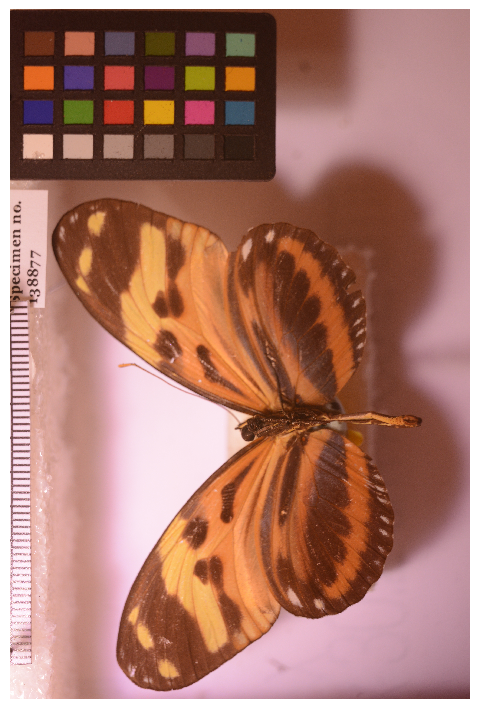

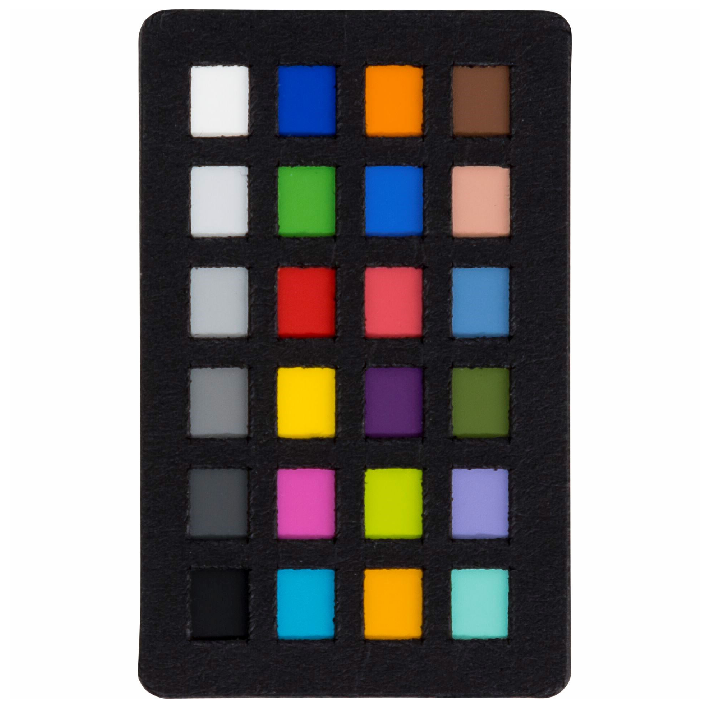

In [25]:
#color detection tool from github:
# https://github.com/colour-science/colour-checker-detection/blob/master/colour_checker_detection/examples/examples_detection.ipynb
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

import colour

from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    SETTINGS_SEGMENTATION_COLORCHECKER_CLASSIC,
    colour_checkers_coordinates_segmentation,
    detect_colour_checkers_segmentation)
from colour_checker_detection.detection.segmentation import (
    adjust_image)

colour.plotting.colour_style()

#colour.utilities.describe_environment()

ROOT_RESOURCES_EXAMPLES="./input/4.May/"

COLOUR_CHECKER_IMAGE_PATHS = glob.glob(
    
    os.path.join(ROOT_RESOURCES_EXAMPLES, '*.png'))

print(COLOUR_CHECKER_IMAGE_PATHS)

COLOUR_CHECKER_IMAGES = [
    colour.cctf_decoding(colour.io.read_image(path))
    for path in COLOUR_CHECKER_IMAGE_PATHS
]

for image in COLOUR_CHECKER_IMAGES:
    colour.plotting.plot_image(colour.cctf_encoding(image));
    

In [165]:
#gets edges from the image, from github
COLOUR_CHECKER_IMAGE_PATHS
i=0
for image in COLOUR_CHECKER_IMAGES:
    colour_checkers, clusters, swatches, segmented_image = (
        colour_checkers_coordinates_segmentation(
            image, additional_data=True).values)
    
    plt.imshow(segmented_image,cmap='Greys_r')
    plt.axis('off')
    print(os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i]))
    plt.savefig(ROOT_RESOURCES_EXAMPLES+"edge_"+os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i]))
    i=i+1

    

138877_VR.png
whole_color_checker.png


In [194]:
#modified INPUT crop color checker image pixel values each

import numpy as np
from PIL import Image, ImageDraw

image = Image.open('./input/crop.png')

pixels_cropped=((170, 60),(240,70),(310,80),
       (150, 150),(220,160),(290,170),(350,180),
       (140, 230),(210,240),(280,250),(340,260),
       (120, 320),(190,330),(270,340),(330,350),
       (110, 400),(180,410),(250,420),(320,430),
       (90, 480),(160,490),(230,500),(300,510))

input_array=[]
input_red_array=[]
input_green_array=[]
input_blue_array=[]

for i in range(23):
    pixel_value = image.getpixel(pixels_cropped[i])
    rgb_value=[pixel_value[0],pixel_value[1],pixel_value[2]]
    input_red_array.append([pixel_value[0]])
    input_green_array.append([pixel_value[1]])
    input_blue_array.append([pixel_value[2]])
    input_array.append(rgb_value)

    # Draw a white point on the pixel
    draw = ImageDraw.Draw(image)
    draw.point(pixels_cropped[i], fill=(255, 255, 255))  # (255, 255, 255) is white
    del draw 

image.save('modified_crop_example.png')
#This have to change according to input data

In [68]:
# Trying to allign!

import numpy as np

#img1 = cv2.imread('./input/4.May/edge_138877_VR.png')
#img2 = cv2.imread('./input/4.May/edge_whole_color_checker.png')
#path = './output/edge_whole_color_checker_edge_138877_VR_matches.npz'

img1 = cv2.imread('./input/4.May/138877_VR.JPG')
img2 = cv2.imread('./input/4.May/whole_color_checker.png')
path = './output/whole_color_checker_138877_VR_matches.npz'

npz = np.load(path)
print(np.sum(npz['matches']>-1))
print(npz['keypoints0'].shape)
print(npz['keypoints1'].shape)
print(npz['matches'].shape)

pt_src=np.empty((0, 2)) 
pt_dst=np.empty((0, 2)) 
for i in range(npz['matches'].shape[0]):
    if npz['matches'][i] > -1:
        point=np.asarray(list(npz['keypoints0'][i])).reshape((1,2))
        pt_src=np.append(pt_src,point,axis=0)
        point=np.asarray(list(npz['keypoints1'][npz['matches'][i]])).reshape((1,2))
        pt_dst=np.append(pt_dst,point,axis=0)

print("source:",pt_src.shape)
print("destination:",pt_dst.shape)
H, _ = cv2.findHomography(pt_src, pt_dst, cv2.RANSAC)
aligned_img = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
cv2.imwrite('aligned_image.jpg', aligned_img)

50
(218, 2)
(667, 2)
(218,)
source: (50, 2)
destination: (50, 2)


True

In [195]:
#TARGET color checker image pixel values each

from matplotlib import image
from matplotlib import pyplot as plt
# to read the image stored in the working directory
data = cv2.imread('./input/whole_color_checker.png')
image = Image.open('./input/whole_color_checker.png')

pixels_in_full=((570, 200),(830,200),(1060,200),
       (570, 540),(830,540),(1060,540),(1310,540),
       (570, 840),(830,840),(1060,840),(1310,840),
       (570, 1080),(830,1080),(1060,1080),(1310,1080),
       (570, 1340),(830,1340),(1060,1340),(1310,1340),
       (570, 1640),(830,1640),(1060,1640),(1310,1640))

target_array=[]
target_red_array=[]
target_green_array=[]
target_blue_array=[]
for i in range(23):
    pixel_value =  image.getpixel(pixels_in_full[i])
    rgb_value=[pixel_value[0],pixel_value[1],pixel_value[2]]
    target_red_array.append([pixel_value[0]])
    target_green_array.append([pixel_value[1]])
    target_blue_array.append([pixel_value[2]])
    target_array.append(rgb_value)
    
    plt.plot(pixels_in_full[i][0], pixels_in_full[i][1], marker='v', color="white")
    
plt.imshow(data)
#plt.show()
plt.savefig('modified_full_example.png')

#This does not have to change

In [203]:
# Turn into TENSOR the images
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# Trying different regression model
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn import linear_model

def return_model(np_input,np_target):

    inputs = np.array(np_input)
    targets = np.array(np_target)

    # Convert the data to PyTorch tensors
    inputs = torch.from_numpy(inputs).float()
    targets = torch.from_numpy(targets).float()
    
    ransac = RANSACRegressor(base_estimator=LinearRegression(), max_trials=1000)
    ransac.fit(inputs, targets)
    print("ransac score:")
    print(ransac.score(inputs, targets))
    print("linear regression:")
    reg = linear_model.LinearRegression()
    reg.fit(inputs, targets)
    print(reg.score(inputs, targets))

    for i in range(1, 9):
        ridge = linear_model.Ridge(alpha=i*.5)
        ridge.fit(inputs, targets)
        #print(ridge.score(inputs, targets))

    #print("lassoModel")
    for i in range(1, 9):
        lassoModel = linear_model.Lasso(alpha = i * 0.25, tol = 0.0925)
        lassoModel.fit(inputs, targets)
        #print(lassoModel.score(inputs, targets))
    return reg


In [214]:
#return_model(input_array,target_array)
reg_red= return_model(input_red_array,target_red_array)
reg_green= return_model(input_green_array,target_green_array)
reg_blue= return_model(input_blue_array,target_blue_array)


import math

#image = Image.open('./input/crop_1_30.jpg')
image = Image.open('./input/crop.png')

# Get shape of image
width, height = image.size
print(width," ",height)

for x in range(width):
    for y in range(height):
        pixel = image.getpixel((x, y))
        pixel_tensor = torch.tensor([[pixel[0]]], dtype=torch.float)
        new_pixel_r=reg_red.predict(pixel_tensor).astype(int)
        pixel_tensor = torch.tensor([[pixel[1]]], dtype=torch.float)
        new_pixel_g=reg_green.predict(pixel_tensor).astype(int)
        pixel_tensor = torch.tensor([[pixel[2]]], dtype=torch.float)
        new_pixel_b=reg_blue.predict(pixel_tensor).astype(int)
        image.putpixel((x, y),(new_pixel_r[0][0],new_pixel_g[0][0],new_pixel_b[0][0]))
image=image.convert('RGB')
image.save('my_modified_image.jpg')



ransac score:
0.946192804732
linear regression:
0.946192804732
ransac score:
0.879216359278
linear regression:
0.879216359278
ransac score:
0.906661044194
linear regression:
0.906661044194
367   614


In [153]:
#Transforming image to actual color
import math

image = Image.open('./input/crop_1_30.jpg')
#image = Image.open('./input/crop.png')

# Get shape of image
width, height = image.size
print(width," ",height)

for x in range(width):
    for y in range(height):
        pixel = image.getpixel((x, y))
        pixel_tensor = torch.tensor([[pixel[0], pixel[1], pixel[2]]], dtype=torch.float)
        new_pixel=reg.predict(pixel_tensor).astype(int)
        image.putpixel((x, y),tuple(new_pixel[0]))
image=image.convert('RGB')
image.save('my_modified_image.jpg')

1800   1200


In [228]:
# actual and predicted difference
import math
image = Image.open('./input/crop.png')
difference=0
for i in range(23):
    pixel_value = image.getpixel(pixels_cropped[i])
    rgb_value=[pixel_value[0],pixel_value[1],pixel_value[2]]
    print(rgb_value)
    a = torch.tensor([[pixel_value[0]]], dtype=torch.float)
    b=torch.tensor([[pixel_value[1]]], dtype=torch.float)
    c=torch.tensor([[pixel_value[2]]], dtype=torch.float)
    print("predicted=",reg_red.predict(a).astype(int)[0][0],\
          reg_green.predict(b).astype(int)[0][0],\
          reg_blue.predict(c).astype(int)[0][0], ", target=",target_array[i])
    difference=difference+math.sqrt(abs((reg_red.predict(a).astype(int)[0][0]-target_array[i][0])^2\
                    +(reg_green.predict(b).astype(int)[0][0]-target_array[i][1])^2\
                    +(reg_blue.predict(c).astype(int)[0][0]-target_array[i][2])^2))
    
print(difference/23)

[234, 186, 164]
predicted= 269 260 277 , target= [239, 239, 239]
[53, 37, 111]
predicted= 23 60 185 , target= [0, 59, 179]
[226, 103, 36]
predicted= 258 148 55 , target= [251, 133, 1]
[206, 163, 146]
predicted= 231 229 246 , target= [218, 219, 224]
[92, 116, 28]
predicted= 76 166 41 , target= [74, 170, 45]
[81, 55, 124]
predicted= 61 84 207 , target= [9, 99, 209]
[187, 106, 80]
predicted= 205 152 131 , target= [224, 166, 146]
[178, 139, 124]
predicted= 193 196 207 , target= [180, 185, 189]
[191, 50, 32]
predicted= 211 77 48 , target= [210, 32, 28]
[199, 70, 59]
predicted= 221 104 95 , target= [228, 76, 88]
[90, 73, 91]
predicted= 74 108 150 , target= [76, 136, 188]
[131, 96, 83]
predicted= 129 139 136 , target= [130, 131, 135]
[218, 156, 19]
predicted= 247 219 26 , target= [254, 208, 0]
[95, 25, 62]
predicted= 80 43 100 , target= [84, 43, 103]
[77, 60, 4]
predicted= 56 90 0 , target= [87, 105, 43]
[80, 53, 42]
predicted= 60 81 65 , target= [68, 73, 77]
[206, 65, 108]
predicted= 231 97 